In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["figure.dpi"] = 150

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import zipfile

# DS imports
import pandas as pd

In [3]:
DATA_DIR = pathlib.Path("../data/dataset")

# Данные

Структура архива и метаданных не вполне удобна для работы. Например:
    
- в именах директорий встречаются кириллические символы в кодировке Windows, которые не отображаются корректно в других ОС,
- структура метаданных затрудняет их непосредственное чтение программными средствами ("в одну строку/команду"),
- и `.frame`, и `.bmp` форматы неудобны для хранения и чтения.

Поэтому:

- распаковываем архив программно, переименовываем/переводим в другую кодировку (с помощью `iconv`),
- метаданные преобразуем и пересохраним в CSV,
- кадры сохраним в бинарном формате NumPy.

Весь код, необходимый для преобразований, указанных выше, упакуем в отдельный пакет Python для использования с новыми снимками.

## Чтение файлов `.cfg`

Файл с именами классов преобразуем вручную, а файлы с разметкой - программно.

In [4]:
from typing import Union, Optional

In [5]:
def parse_cfg(f: Union[str, pathlib.Path]) -> pd.DataFrame:
    """Parse ground truth `.cfg` file into Pandas dataframe."""

    f = pathlib.Path(f)

    with open(f, "r") as fl:
        lines = [s.strip() for s in fl.readlines()]

    target = []

    fname = None
    defects = None

    for l in lines:
        tokens = l.split(", ")

        if len(tokens) == 1:

            if fname is not None:
                target.extend(defects)

            fname = l
            defects = []
        else:
            defects.append([fname] + [int(t) for t in tokens])

    if defects:
        target.extend(defects)

    return pd.DataFrame(target, columns=["frame", "x", "y", "label"])

In [6]:
FULL_FILE = DATA_DIR.joinpath("metadata", "set-iconv.cfg")
TEST_FILE = DATA_DIR.joinpath("metadata", "test_set-iconv.cfg")

full_target = parse_cfg(FULL_FILE)
test_target = parse_cfg(TEST_FILE)

In [7]:
full_target

,frame,x,y,label
0,0\1538\frame0006.frame,809,336,3
1,0\1538\frame0006.frame,601,299,0
2,0\1538\frame0007.frame,667,318,3
3,0\1538\frame0007.frame,811,523,3
4,0\1538\frame0007.frame,445,300,0
...,...,...,...,...
38008,2023.10.25\5_896.frame,121,418,1
38009,2023.10.25\5_896.frame,568,94,0
38010,2023.10.25\5_896.frame,509,153,0
38011,2023.10.25\5_896.frame,509,330,0


In [8]:
full_target["frame"] = full_target["frame"].apply(lambda v: pathlib.PureWindowsPath(v).as_posix())

In [9]:
test_target

,frame,x,y,label
0,0\1538\frame0006.frame,809,336,3
1,0\1538\frame0007.frame,667,318,3
2,0\1538\frame0007.frame,811,523,3
3,0\1538\frame0009.frame,576,313,3
4,0\1538\frame0009.frame,724,509,3
...,...,...,...,...
7717,2023.10.25\5_682.frame,568,448,0
7718,2023.10.25\5_874.frame,214,212,0
7719,2023.10.25\5_874.frame,509,389,0
7720,2023.10.25\5_882.frame,745,271,0


In [10]:
test_target["frame"] = test_target["frame"].apply(lambda v: pathlib.PureWindowsPath(v).as_posix())

Проверяем пересечение:

In [11]:
test_target.merge(full_target.drop("label", axis=1),
                  on=["frame", "x", "y"],
                  how="left",
                  indicator=True)._merge.value_counts()

_merge
both          7722
left_only        0
right_only       0
Name: count, dtype: int64

Таким образом, файл `set.cfg` содержит все кадры, а файл `test_set.cfg` -  только тестовое множество. Сохраним кадры (не дефекты!), которые не встречаются в тестовом множестве, отдельно:

In [12]:
train_frame_target = full_target[~full_target.frame.isin(test_target.frame)].reset_index(drop=True)
train_frame_target

,frame,x,y,label
0,0/miss/0_086.frame,757,457,0
1,0/miss/0_168.frame,480,171,0
2,0/miss/0_168.frame,500,452,0
3,0/miss/0_350.frame,455,131,0
4,0/miss/0_350.frame,768,505,0
...,...,...,...,...
14847,2023.10.25/5_878.frame,273,153,0
14848,2023.10.25/5_878.frame,686,330,0
14849,2023.10.25/5_878.frame,332,389,0
14850,2023.10.25/5_878.frame,450,448,0


In [13]:
test_frame_target = pd.concat([full_target[full_target.frame.isin(test_target.frame)],
                               test_target], ignore_index=True)
test_frame_target

,frame,x,y,label
0,0/1538/frame0006.frame,809,336,3
1,0/1538/frame0006.frame,601,299,0
2,0/1538/frame0007.frame,667,318,3
3,0/1538/frame0007.frame,811,523,3
4,0/1538/frame0007.frame,445,300,0
...,...,...,...,...
30878,2023.10.25/5_682.frame,568,448,0
30879,2023.10.25/5_874.frame,214,212,0
30880,2023.10.25/5_874.frame,509,389,0
30881,2023.10.25/5_882.frame,745,271,0


In [14]:
train_frame_target.to_csv(DATA_DIR.joinpath("train_frame_target.csv"), index=None)
test_frame_target.to_csv(DATA_DIR.joinpath("test_frame_target.csv"), index=None)

Также создадим более мягкое тренировочное множества, в котором есть только дефекты, не встречающиеся в тестовом множестве (независимо от того, встречаются ли в тестовом множестве соответствующие кадры):

In [15]:
df = full_target.merge(test_target.drop("label", axis=1),
                       on=["frame", "x", "y"],
                       how="left",
                       indicator=True)
train_defect_target = df[df._merge=="left_only"].drop("_merge", axis=1).reset_index(drop=True)

In [16]:
train_defect_target.to_csv(DATA_DIR.joinpath("train_defect_target.csv"), index=None)
test_target.to_csv(DATA_DIR.joinpath("test_defect_target.csv"), index=None)

# Проверка на здравый смысл

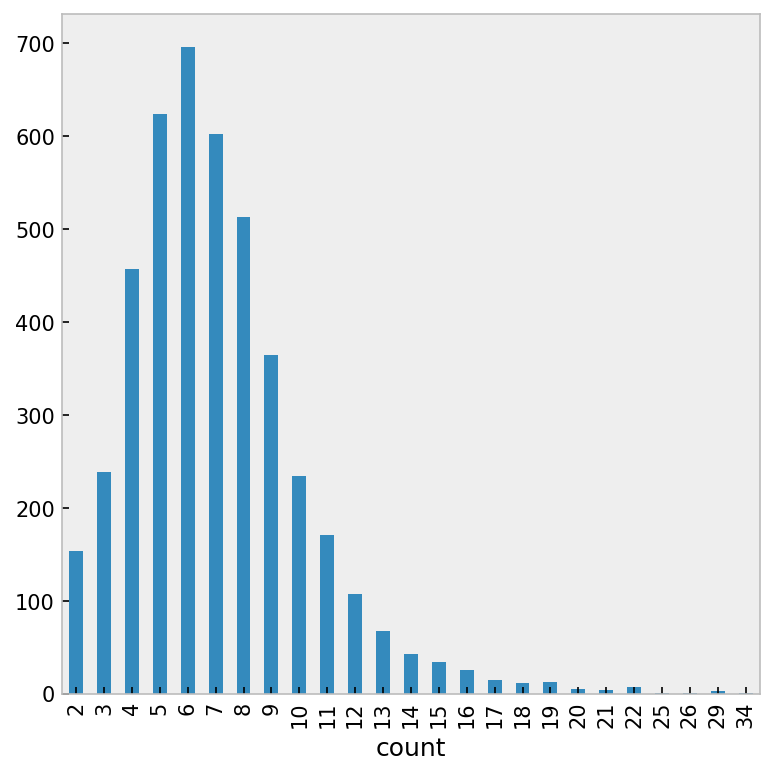

In [17]:
test_frame_target.frame.value_counts().value_counts().sort_index().plot(kind="bar")
# train_frame_target.frame.value_counts().value_counts().sort_index().plot(kind="bar", ax=plt.gca())

plt.grid(None)

Text(0, 0.5, 'кол-во кадров')

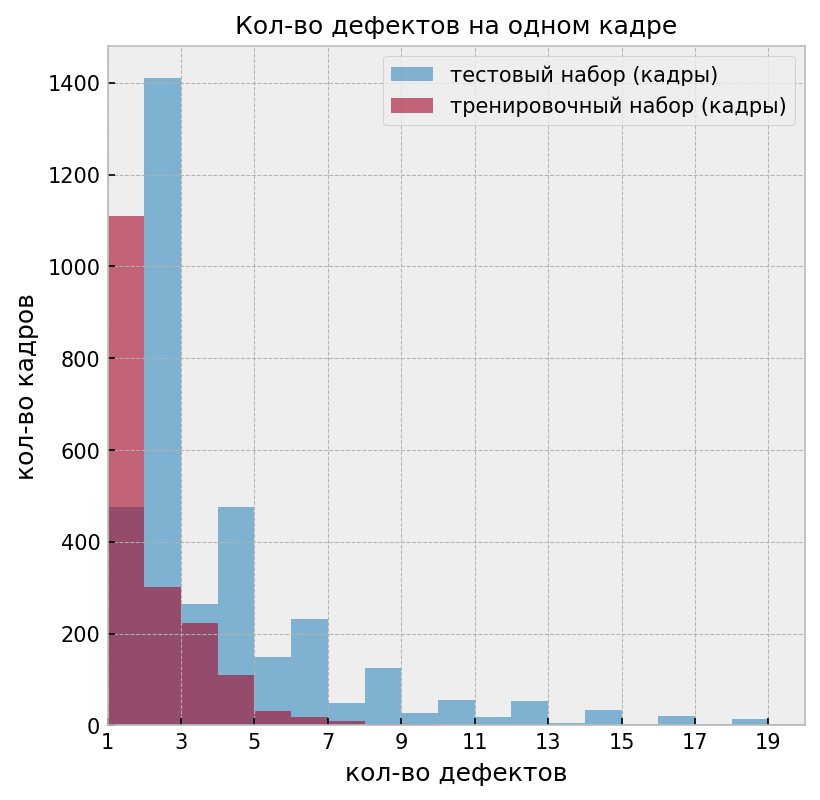

In [18]:
test_frame_target[test_frame_target.label!=0].frame.value_counts().plot(kind="hist",
                                                                        label="тестовый набор (кадры)",
                                                                        alpha=0.6,
                                                                        range=(1, 21),
                                                                        bins=20)
train_frame_target[train_frame_target.label!=0].frame.value_counts().plot(kind="hist",
                                                                          label="тренировочный набор (кадры)",
                                                                          alpha=0.6,
                                                                          range=(1, 21),
                                                                          bins=20)

plt.legend(loc=0)
plt.xlim(1, 20)
plt.xticks(np.arange(1, 20, 2))
plt.title("Кол-во дефектов на одном кадре", fontsize=12)
plt.xlabel("кол-во дефектов")
plt.ylabel("кол-во кадров")

Text(0, 0.5, 'кол-во кадров')

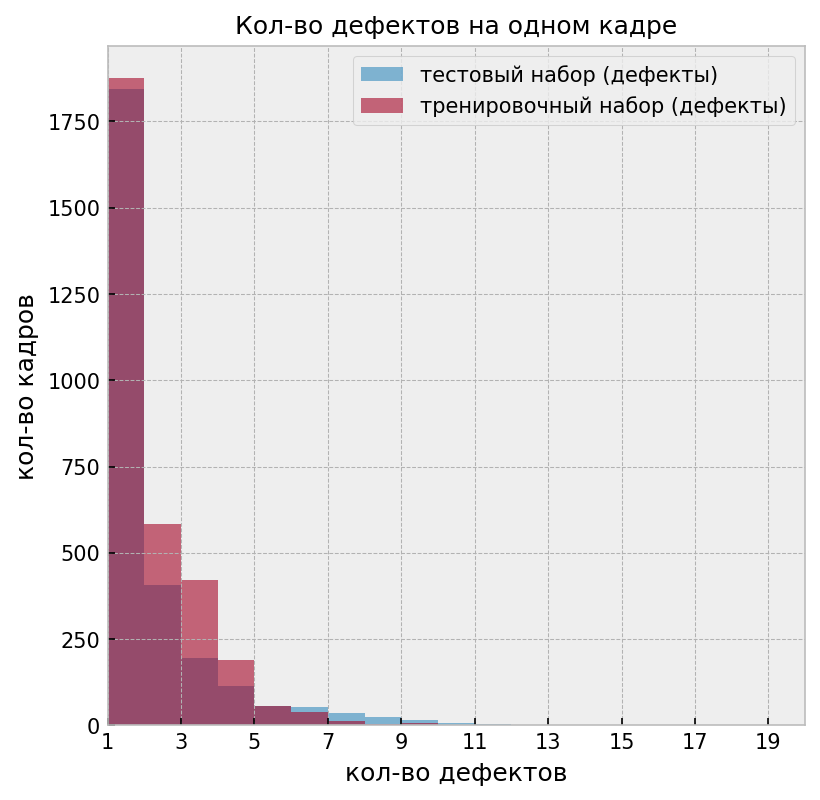

In [19]:
test_target[test_target.label!=0].frame.value_counts().plot(kind="hist",
                                                            label="тестовый набор (дефекты)",
                                                            alpha=0.6,
                                                            range=(1, 21),
                                                            bins=20)
train_defect_target[train_defect_target.label!=0].frame.value_counts().plot(kind="hist",
                                                                            label="тренировочный набор (дефекты)",
                                                                            alpha=0.6,
                                                                            range=(1, 21),
                                                                            bins=20)

plt.legend(loc=0)
plt.xlim(1, 20)
plt.xticks(np.arange(1, 20, 2))
plt.title("Кол-во дефектов на одном кадре", fontsize=12)
plt.xlabel("кол-во дефектов")
plt.ylabel("кол-во кадров")

## Классы дефектов

In [20]:
class_names = pd.read_csv(DATA_DIR.joinpath("metadata", "classes.csv"))
class_names

,colorcode,class,classname
0,66FF66AA,0,не дефект
1,8833FFFF,1,потертость
2,0000FFFF,2,черная точка
3,FF8800FF,3,плена
4,FF0000FF,4,маркер
5,AE7C10FF,5,грязь
6,FFFFFFFF,6,накол
7,FFDDAAFF,7,н.д. накол
8,FF00FFFF,8,микровыступ
9,880088FF,9,н.д. микровыступ


In [21]:
(train_frame_target
 .merge(class_names.drop("colorcode", axis=1), left_on="label", right_on="class", how="left")
 .classname
 .value_counts())

classname
не дефект           11634
потертость           2248
н.д. микровыступ      622
микровыступ           348
Name: count, dtype: int64

In [22]:
(test_frame_target
 .merge(class_names.drop("colorcode", axis=1), left_on="label", right_on="class", how="left")
 .classname
 .value_counts())

classname
не дефект             18193
потертость             3113
грязь                  2952
маркер                 2378
мех.повреждение         722
черная точка            632
накол                   558
н.д. микровыступ        537
плена                   466
царапина с волчком      388
н.д. накол              382
микровыступ             300
риска                   154
вмятина                 108
Name: count, dtype: int64

In [23]:
(train_defect_target
 .merge(class_names.drop("colorcode", axis=1), left_on="label", right_on="class", how="left")
 .classname
 .value_counts())

classname
не дефект           24461
потертость           4373
н.д. микровыступ      941
микровыступ           516
Name: count, dtype: int64

In [24]:
(test_target
 .merge(class_names.drop("colorcode", axis=1), left_on="label", right_on="class", how="left")
 .classname
 .value_counts())

classname
не дефект             2683
грязь                 1476
маркер                1189
потертость             494
мех.повреждение        361
черная точка           316
накол                  279
плена                  233
царапина с волчком     194
н.д. накол             191
н.д. микровыступ       109
риска                   77
микровыступ             66
вмятина                 54
Name: count, dtype: int64

Таким образом, в тестовом наборе есть классы, которых нет в тренировочном множестве. Следовательно, данные придётся переразбить.

# Чтение изображений

In [25]:
sample_file = DATA_DIR.joinpath("FRAMES", "0", "410", "frame0000.frame")

In [26]:
with open(sample_file, "rb") as f:
    data = f.read()

In [27]:
shape = np.frombuffer(data[:8], dtype=np.int32)
img = np.frombuffer(data, dtype=np.int8, offset=8)

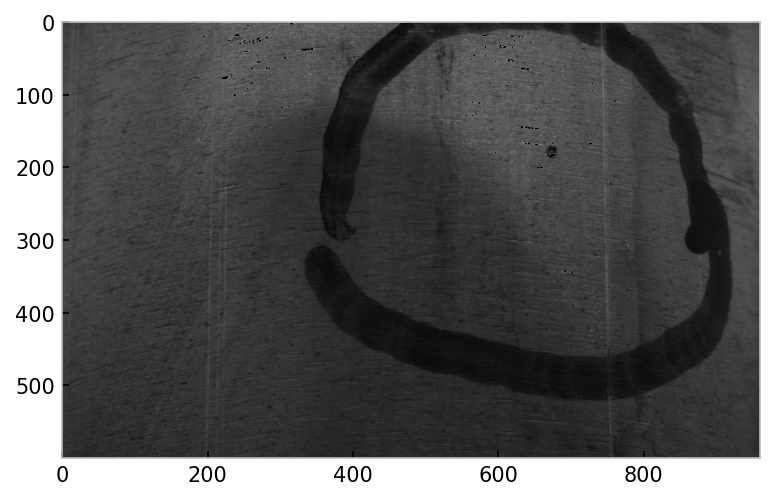

In [28]:
plt.imshow(img.reshape(shape[::-1]), cmap=plt.cm.gray, vmin=0, vmax=256)
plt.grid(None)

In [29]:
def read_frame(fname: Union[str, pathlib.Path]) -> np.ndarray:
    """Read binary frame data."""

    fname = pathlib.Path(fname)

    with open(fname, "rb") as f:
        data = f.read()

    shape = np.frombuffer(data[:8], dtype=np.uint32)
    img = np.frombuffer(data, dtype=np.uint8, offset=8)

    return img.reshape(shape[::-1])

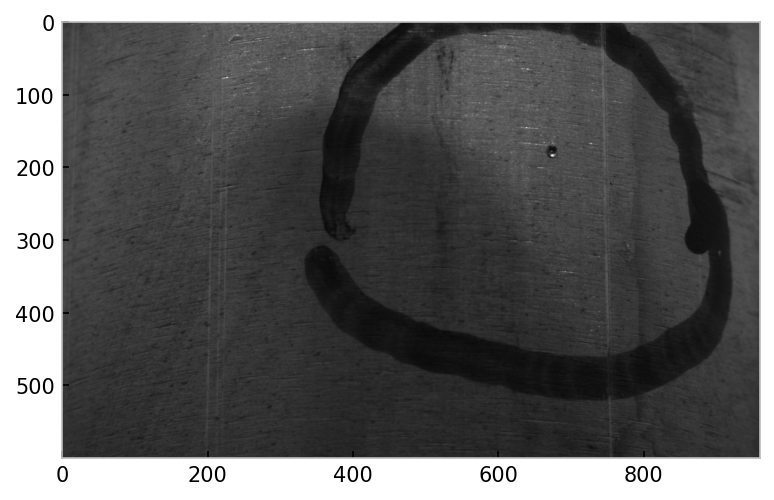

In [30]:
plt.imshow(read_frame(sample_file), cmap=plt.cm.gray, vmin=0, vmax=256)
plt.grid(None)

In [31]:
img = read_frame(sample_file)

In [32]:
np.save(DATA_DIR.joinpath("FRAMES", "0", "410", "frame0000.npy"), img)

Сравним эффективность чтения:

In [33]:
%timeit -n 3 -r 3 np.load(DATA_DIR.joinpath("FRAMES", "0", "410", "frame0000.npy"))

585 µs ± 213 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [34]:
%timeit -n 3 -r 3 img = read_frame(sample_file)

The slowest run took 7.36 times longer than the fastest. This could mean that an intermediate result is being cached.
183 µs ± 171 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


Таким образом, удобнее читать данные в формате `frame`.

# Файлы

In [35]:
import os

In [36]:
frames_dir = DATA_DIR.joinpath("FRAMES")

In [52]:
frames_filter = [(root, dirs, files)
                 for root, dirs, files in os.walk(frames_dir)
                 if len(files)!=0]

In [53]:
frames_combined = [[(pathlib.Path(root)
                     .joinpath(fname)
                     .relative_to(DATA_DIR.joinpath("FRAMES"))
                     .as_posix())
                    for fname in files]
                   for root, _, files in frames_filter]

In [54]:
frames = pd.concat([pd.DataFrame({"frame": files}) for files in frames_combined], ignore_index=True)

In [55]:
frames = frames[frames.frame.str.contains("\.frame")]
frames

,frame
1,frame0000.frame
3,2023.07.19 58-23-04_1/4_714.frame
5,2023.07.19 58-23-04_1/4_744.frame
6,2023.07.19 58-23-04_1/0_121.frame
8,2023.07.19 58-23-04_1/0_493.frame
...,...
15609,2023.10.10 804-23-04_1/1/5_402.frame
15610,2023.10.10 804-23-04_1/0/4_491.frame
15612,2023.10.10 804-23-04_1/0/5_402.frame
15614,2023.10.10 804-23-04_1/0/2_562.frame


Проверим, все ли кадры имеют разметку и все ли кадры из разметки присутствуют физически:

In [56]:
combined_target = pd.concat([full_target, test_target])
combined_target = (combined_target
                   .drop_duplicates(subset=["frame", "x", "y"])
                   .frame.value_counts().rename("num_defects")
                   .to_frame()
                   .reset_index())

In [57]:
combined_target

,frame,num_defects
0,2020.10.25/0_526.frame,17
1,2020.10.17/Труба 4/1_754.frame,16
2,2020.10.16/Труба 9/1_115.frame,15
3,2023.01.11/4_557.frame,15
4,2023.10.25/3_856.frame,15
...,...,...
7735,2022.10.31/t17_dist_1_frame_2.frame,1
7736,2023.05.16/5_145.frame,1
7737,2023.05.16/4_620.frame,1
7738,2023.04.18/3_135.frame,1


In [58]:
combined_target.frame.isin(frames.frame).value_counts()

frame
True     6841
False     899
Name: count, dtype: int64

Т. е., некоторые кадры, которые присутствуют в разметке, отсутствуют в датасете.

In [59]:
frames.frame.isin(combined_target.frame).value_counts()

frame
True     6841
False     967
Name: count, dtype: int64

Многие кадры, которые физически есть на диске, отсутствуют в разметке. Будем считать, что дефектов на них нет.

In [60]:
frames

,frame
1,frame0000.frame
3,2023.07.19 58-23-04_1/4_714.frame
5,2023.07.19 58-23-04_1/4_744.frame
6,2023.07.19 58-23-04_1/0_121.frame
8,2023.07.19 58-23-04_1/0_493.frame
...,...
15609,2023.10.10 804-23-04_1/1/5_402.frame
15610,2023.10.10 804-23-04_1/0/4_491.frame
15612,2023.10.10 804-23-04_1/0/5_402.frame
15614,2023.10.10 804-23-04_1/0/2_562.frame


In [61]:
frames["has_target"] = frames.frame.isin(full_target.frame).astype(int)

In [62]:
dimensions = []

for _, frame in frames.iterrows():
    try:
        img = read_frame(DATA_DIR.joinpath("FRAMES", frame.frame))
        dimensions.append([frame.frame, True]
                          + list(img.shape[::-1])
                          + [img.min(), img.max(), img.mean(), np.median(img)])
    except Exception as e:
        print(f"{frame.frame} is broken ({e})")
        dimensions.append([frame.frame, False] + [None, None, None, None, None, None])

In [63]:
dimensions = pd.DataFrame(dimensions,
                          columns=["frame", "valid", "dim_x", "dim_y", "min", "max", "mean", "median"])
dimensions

,frame,valid,dim_x,dim_y,min,max,mean,median
0,frame0000.frame,True,960,600,14,255,103.001401,108.0
1,2023.07.19 58-23-04_1/4_714.frame,True,960,600,50,255,127.412597,126.0
2,2023.07.19 58-23-04_1/4_744.frame,True,960,600,41,243,128.178547,127.0
3,2023.07.19 58-23-04_1/0_121.frame,True,960,600,59,255,151.415082,152.0
4,2023.07.19 58-23-04_1/0_493.frame,True,960,600,62,220,146.332135,148.0
...,...,...,...,...,...,...,...,...
7803,2023.10.10 804-23-04_1/1/5_402.frame,True,960,600,65,228,146.972727,146.0
7804,2023.10.10 804-23-04_1/0/4_491.frame,True,960,600,49,238,128.822977,128.0
7805,2023.10.10 804-23-04_1/0/5_402.frame,True,960,600,70,231,145.217594,144.0
7806,2023.10.10 804-23-04_1/0/2_562.frame,True,960,600,45,255,145.899250,144.0


In [64]:
frames = frames.merge(dimensions, on="frame", how="left")
frames["valid"] = frames["valid"].astype(int)
frames

,frame,has_target,valid,dim_x,dim_y,min,max,mean,median
0,frame0000.frame,0,1,960,600,14,255,103.001401,108.0
1,2023.07.19 58-23-04_1/4_714.frame,1,1,960,600,50,255,127.412597,126.0
2,2023.07.19 58-23-04_1/4_744.frame,1,1,960,600,41,243,128.178547,127.0
3,2023.07.19 58-23-04_1/0_121.frame,1,1,960,600,59,255,151.415082,152.0
4,2023.07.19 58-23-04_1/0_493.frame,1,1,960,600,62,220,146.332135,148.0
...,...,...,...,...,...,...,...,...,...
7803,2023.10.10 804-23-04_1/1/5_402.frame,1,1,960,600,65,228,146.972727,146.0
7804,2023.10.10 804-23-04_1/0/4_491.frame,1,1,960,600,49,238,128.822977,128.0
7805,2023.10.10 804-23-04_1/0/5_402.frame,1,1,960,600,70,231,145.217594,144.0
7806,2023.10.10 804-23-04_1/0/2_562.frame,1,1,960,600,45,255,145.899250,144.0


Т. о., все кадры имеют одинаковый размер, это немного упрощает работу. Создадим окончательные файлы с разметкой:

In [65]:
(train_defect_target[train_defect_target.frame.isin(frames[frames.valid==1].frame)]
 .to_csv(DATA_DIR.joinpath("train_defect_target_clean.csv"), index=None))

(test_target[test_target.frame.isin(frames[frames.valid==1].frame)]
 .to_csv(DATA_DIR.joinpath("test_defect_target_clean.csv"), index=None))

(train_frame_target[train_frame_target.frame.isin(frames[frames.valid==1].frame)]
 .to_csv(DATA_DIR.joinpath("train_frame_target_clean.csv"), index=None))

(test_frame_target[test_frame_target.frame.isin(frames[frames.valid==1].frame)]
 .to_csv(DATA_DIR.joinpath("test_frame_target_clean.csv"), index=None))

In [66]:
frames.to_csv(DATA_DIR.joinpath("frames.csv"), index=None)